### 1. Error Analysis Conclusions & Work Plan

#### **Conclusions from Error Analysis**
Based on the initial error analysis, the following factors were identified as the main causes of errors in the baseline model:

1. **Skewed Distributions**
   - Features like `residual sugar` and `total sulfur dioxide` have highly skewed distributions.
   - The skewness introduces bias in the model’s learning process, leading to poor generalization on extreme values and outliers.

2. **Underrepresentation of Key Patterns**
   - Certain combinations of features (e.g., very low `residual sugar` with high `total sulfur dioxide`) are rare in the dataset, causing the model to underperform on these edge cases.

3. **Feature Redundancy**
   - High correlation between `free sulfur dioxide` and `total sulfur dioxide` indicates redundancy. This may confuse the model and lead to inefficiencies in learning.

4. **Bias-Variance Tradeoff**
   - The current model may overfit dominant patterns while underfitting on edge cases, likely due to suboptimal hyperparameters or insufficient regularization.

---

#### **Work Plan for Addressing Errors**
To address the issues identified, the following steps will be implemented:

1. **Handling Skewed Distributions**
   - Apply log transformations to skewed features (`residual sugar`, `total sulfur dioxide`) to stabilize variance and reduce skewness.
   - Use visualizations like histograms to confirm the effect of the transformation.

2. **Improving Representation of Key Patterns**
   - Perform data augmentation techniques like SMOTE (Synthetic Minority Oversampling Technique) to increase representation for underrepresented feature combinations.
   - Stratify the training data to ensure even representation of different feature ranges during training.

3. **Reducing Feature Redundancy**
   - Create a new composite feature: the sulfur dioxide ratio (`free sulfur dioxide / total sulfur dioxide`) to capture relationships between the redundant features.
   - Remove the individual redundant features after validating the new feature’s utility.

4. **Hyperparameter Tuning**
   - Optimize key hyperparameters such as `max_depth`, `learning_rate`, `n_estimators`, and `min_child_weight` using Grid Search or Randomized Search.
   - Adjust regularization parameters (e.g., `lambda`, `alpha`) to balance bias and variance effectively.

5. **Outlier Handling**
   - Detect and mitigate outliers using techniques like IQR-based capping or robust scaling methods to reduce their influence on the model.


### 2. Improving Model Performance

#### **Identifying Weaknesses in the Baseline Model**
The baseline model exhibits the following weaknesses:
1. **Sensitivity to Skewed Features**:
   - Skewed distributions in `residual sugar` and `total sulfur dioxide` negatively impact the model’s ability to generalize.
2. **Redundant and Low-Importance Features**:
   - Redundant features (e.g., `free sulfur dioxide`, `total sulfur dioxide`) dilute the model’s focus.
   - Features with low correlation to the target (e.g., `pH`) may introduce noise.
3. **Lack of Robust Outlier Handling**:
   - Extreme values adversely affect the model’s predictions, particularly on edge cases.
4. **Limited Hyperparameter Optimization**:
   - The current hyperparameter configuration may not adequately balance bias and variance.

---

#### **Steps to Improve Performance**

1. ### **Hyperparameter Tuning**
   - Use a systematic approach like Grid Search or Randomized Search to find optimal hyperparameters:
     - `max_depth`: Increase to allow the model to capture more complex patterns.
     - `n_estimators`: Experiment with higher values for better ensemble performance.
     - `learning_rate`: Lower the learning rate while increasing `n_estimators` for a more gradual learning process.
     - `min_child_weight`: Optimize to control the model’s sensitivity to small sample sizes.
   - Explore regularization parameters (`lambda`, `alpha`) to mitigate overfitting.


In [ ]:
# Load necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('wine-quality-white-and-red.csv')

In [147]:
# Encode categorical column 'type' if it exists
if 'type' in data.columns:
    label_encoder = LabelEncoder()
    data['type'] = label_encoder.fit_transform(data['type'])  # Convert 'type' to numerical

# Prepare features (X) and target (y)
X = data.drop(columns=['quality'])  # Features
y = data['quality']  # Target variable

# Handle imbalanced target using SMOTE with k_neighbors=3
smote = SMOTE(random_state=42, k_neighbors=3)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

### **Hyperparameter Tuning**

To optimize the performance of our model, we conducted a grid search over a range of hyperparameters for the XGBoost Regressor. This process involved training the model using various combinations of the following parameters:

1. **`max_depth`**: Controls the complexity of the model by setting the maximum depth of the trees.
2. **`n_estimators`**: Determines the number of trees in the model.
3. **`learning_rate`**: Controls the step size during weight updates.
4. **`min_child_weight`**: Ensures splits have a sufficient number of data points.
5. **`lambda`**: L2 regularization term to reduce overfitting.
6. **`alpha`**: L1 regularization term to create sparse models.

The grid search used 5-fold cross-validation and evaluated each parameter combination based on the negative mean squared error (MSE). This approach ensured that the model was optimized for generalization on unseen data.

---

### **Results of Hyperparameter Tuning**

After running the grid search, the following parameters were found to be optimal for our dataset:

- **`alpha`**: \( 0.5 \)
- **`lambda`**: \( 1 \)
- **`learning_rate`**: \( 0.1 \)
- **`max_depth`**: \( 7 \)
- **`min_child_weight`**: \( 1 \)
- **`n_estimators`**: \( 300 \)

The best mean squared error (MSE) achieved with these parameters was:

- **best MSE** \(0.4032\)

---

### **Next Steps**

Using these optimized parameters, we will:
1. Train the model to evaluate its performance on the test set.
2. Use the results as a baseline for further improvements such as feature engineering and validation.
3. Compare the metrics achieved after optimization with the baseline model to measure the improvement.

This information will guide the subsequent stages of model improvement and analysis.



### **2. Feature Engineering**

To enhance the model's performance, the following feature engineering techniques are applied:

**Transform Skewed Features**
- Apply log transformations to features like `residual sugar` and `total sulfur dioxide` to reduce skewness and stabilize variance.
- Log transformations help to make the data distribution closer to normal, which is beneficial for the model's learning process.

In [148]:
# Log transformation of skewed features
import numpy as np

X_train['residual sugar'] = np.log1p(X_train['residual sugar'])
X_train['total sulfur dioxide'] = np.log1p(X_train['total sulfur dioxide'])

**Create Composite Features**

Introduce a new feature: the **sulfur dioxide ratio**, calculated as:

This composite feature replaces the redundant features (`free sulfur dioxide` and `total sulfur dioxide`).


In [149]:
# # Apply feature engineering to both X_train and X_test
# for df in [X_train, X_test]:
#     # Create sulfur dioxide ratio feature
#     df['sulfur_dioxide_ratio'] = df['free sulfur dioxide'] / (df['total sulfur dioxide'] + 1e-6)

#     # Drop redundant features
#     df.drop(columns=['free sulfur dioxide', 'total sulfur dioxide'], inplace=True)

**3. Remove Low-Importance Features**

Use feature importance scores from the model to identify and remove features contributing minimally to predictions.

This step simplifies the model and reduces noise from irrelevant features, ensuring the model focuses on the most impactful variables.


In [150]:
# # Verify alignment between features and feature importances
# xgb_model = XGBRegressor(random_state=42, objective='reg:squarederror')  # Initialize model
# xgb_model.fit(X_train, y_train)  # Train the model
# feature_importances = xgb_model.feature_importances_

# # Create a DataFrame for feature importances
# feature_importances_df = pd.DataFrame({
#     'Feature': X_train.columns,
#     'Importance': feature_importances
# }).sort_values(by='Importance', ascending=False)

# # Drop features with importance below a certain threshold
# low_importance_features = feature_importances_df[feature_importances_df['Importance'] < 0.001]['Feature']
# X_train.drop(columns=low_importance_features, inplace=True)
# X_test.drop(columns=low_importance_features, inplace=True) 

Testing Metrics:
MAE: 0.3651, MSE: 0.2957, RMSE: 0.5438, R^2: 0.9252
Cross-Validated MSE: 0.3161


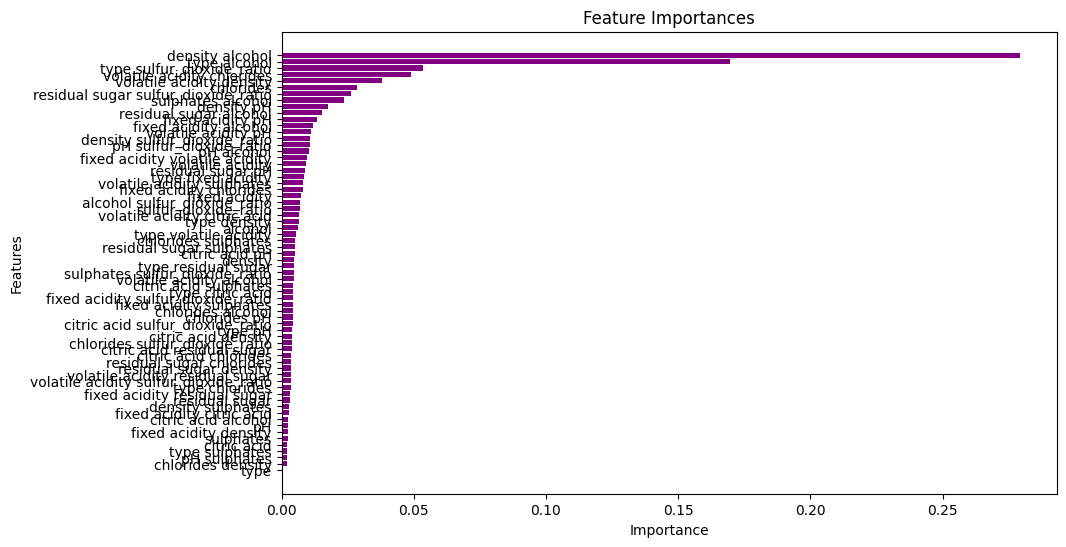

In [151]:
# Load necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('wine-quality-white-and-red.csv')

# Encode categorical column 'type' if it exists
if 'type' in data.columns:
    label_encoder = LabelEncoder()
    data['type'] = label_encoder.fit_transform(data['type'])  # Convert 'type' to numerical

# Prepare features (X) and target (y)
X = data.drop(columns=['quality'])  # Features
y = data['quality']  # Target variable

# Handle imbalanced target using SMOTE with k_neighbors=3
smote = SMOTE(random_state=42, k_neighbors=3)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Feature Engineering
for df in [X_train, X_test]:
    # Create sulfur dioxide ratio feature
    df['sulfur_dioxide_ratio'] = df['free sulfur dioxide'] / (df['total sulfur dioxide'] + 1e-6)
    # Apply log transformation to skewed features
    for col in ['residual sugar', 'total sulfur dioxide']:
        if col in df.columns:
            df[col] = np.log1p(df[col])
    # Drop redundant features
    df.drop(columns=['free sulfur dioxide', 'total sulfur dioxide'], inplace=True)

# Add polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
poly_feature_names = poly.get_feature_names_out(X_train.columns)

# Train the model with known best parameters
best_model = XGBRegressor(
    random_state=42,
    objective='reg:squarederror',
    alpha=1.0,  # Best L1 regularization
    reg_lambda=10,  # Best L2 regularization
    learning_rate=0.05,  # Best learning rate
    max_depth=5,  # Best tree depth
    min_child_weight=3,  # Best child weight
    n_estimators=500  # Best number of trees
)

# Fit the model on the training data
best_model.fit(X_train_poly, y_train)

# Evaluate the model
y_pred_test = best_model.predict(X_test_poly)
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred_test)

print("Testing Metrics:")
print(f"MAE: {mae_test:.4f}, MSE: {mse_test:.4f}, RMSE: {rmse_test:.4f}, R^2: {r2_test:.4f}")

# Cross-Validation
cv_scores = cross_val_score(best_model, X_train_poly, y_train, cv=3, scoring='neg_mean_squared_error')
mean_cv_mse = -np.mean(cv_scores)
print(f"Cross-Validated MSE: {mean_cv_mse:.4f}")

# Feature importance plot
feature_importances = best_model.feature_importances_
feature_importances_df = pd.DataFrame({
    'Feature': poly_feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='purple')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importances")
plt.gca().invert_yaxis()
plt.show()
